**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [53]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import json
import skvideo.io
import cv2

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense,Dropout
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization,Flatten

# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [5]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [6]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The function $\textit{act}$ retuns the action to take for $\textit{train}$ or $\textit{test}$ process. If $\textit{train=True}$, agent takes a random action to explore environment if the initiation is smaller than the threshold epsilon; otherwise, it takes the actions based on state s given by a defined policy. The randomness is used because the agent don't have knowledge on the environment. In $\textit{train}$ process, the threshold seperates $\textit{exploration and exploitation}$ in a random manner.

Espilon is important because it decide the frequency that an agent will explore environment.If epsilon is too small, the agent don't explore enough to learn the environment.The probability of taking a random action in the $\textit{train}$ is epsilon.

A good strategy is to choose a high value of epsilon, close to 1, in the beginning because we don't know anything about values in the table. We can reduce it progressively as the agent becomes more confident at estimating Q-values.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [7]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [80]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train= 200 # set small when debugging
epochs_test=200 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

$\textit{position}$ array is used to mark the current state of the agent. It is initialized with -1 the first,last two rows and the first two columns. These can be considered as $\textbf{walls}$. If the agent is on the position (x,y), the cell will be marked 1.

The broad is used to give corresponding reward for the taken action. It's generated with random positions of cheese and poisson using binomial distribution. 

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [57]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()

    def learned_act(self,s):
        return np.random.randint(4)
#     def learned_act(self, s):
#         return np.random.randint(4)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [58]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()

        win =0
        lose=0
        game_over = False
        
        while not game_over:
            action = agent.act(state)
            state, reward, game_over = env.act(action)
            if reward > 0:
                win = win + reward
            elif reward < 0:
                lose = lose - reward

        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})".format(win, lose, score/(1+e)))

    print('Final score: '+str(score/epochs))

In [82]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 7.5/7.0. Average score (0.5)
Win/lose count 7.0/13.0. Average score (-2.75)
Win/lose count 12.0/15.0. Average score (-2.8333333333333335)
Win/lose count 8.5/12.0. Average score (-3.0)
Win/lose count 10.0/11.0. Average score (-2.6)
Win/lose count 10.5/10.0. Average score (-2.0833333333333335)
Win/lose count 9.5/12.0. Average score (-2.142857142857143)
Win/lose count 11.5/20.0. Average score (-2.9375)
Win/lose count 12.5/8.0. Average score (-2.111111111111111)
Win/lose count 9.0/14.0. Average score (-2.4)
Win/lose count 12.5/11.0. Average score (-2.0454545454545454)
Win/lose count 4.5/14.0. Average score (-2.6666666666666665)
Win/lose count 10.5/20.0. Average score (-3.1923076923076925)
Win/lose count 10.0/14.0. Average score (-3.25)
Win/lose count 8.5/15.0. Average score (-3.466666666666667)
Win/lose count 9.0/19.0. Average score (-3.875)
Win/lose count 11.0/11.0. Average score (-3.6470588235294117)
Win/lose count 10.0/12.0. Average score (-3.5555555555555554)
Win/lose co

Win/lose count 9.0/12.0. Average score (-3.641843971631206)
Win/lose count 9.5/15.0. Average score (-3.6549295774647885)
Win/lose count 11.0/6.0. Average score (-3.5944055944055946)
Win/lose count 11.5/21.0. Average score (-3.6354166666666665)
Win/lose count 10.0/10.0. Average score (-3.610344827586207)
Win/lose count 13.0/16.0. Average score (-3.606164383561644)
Win/lose count 13.5/20.0. Average score (-3.6258503401360542)
Win/lose count 7.5/17.0. Average score (-3.6655405405405403)
Win/lose count 9.5/18.0. Average score (-3.697986577181208)
Win/lose count 18.0/17.0. Average score (-3.6666666666666665)
Win/lose count 15.5/17.0. Average score (-3.652317880794702)
Win/lose count 10.5/14.0. Average score (-3.651315789473684)
Win/lose count 9.0/13.0. Average score (-3.65359477124183)
Win/lose count 9.0/6.0. Average score (-3.6103896103896105)
Win/lose count 11.0/23.0. Average score (-3.664516129032258)
Win/lose count 12.0/14.0. Average score (-3.6538461538461537)
Win/lose count 10.5/14.0.

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




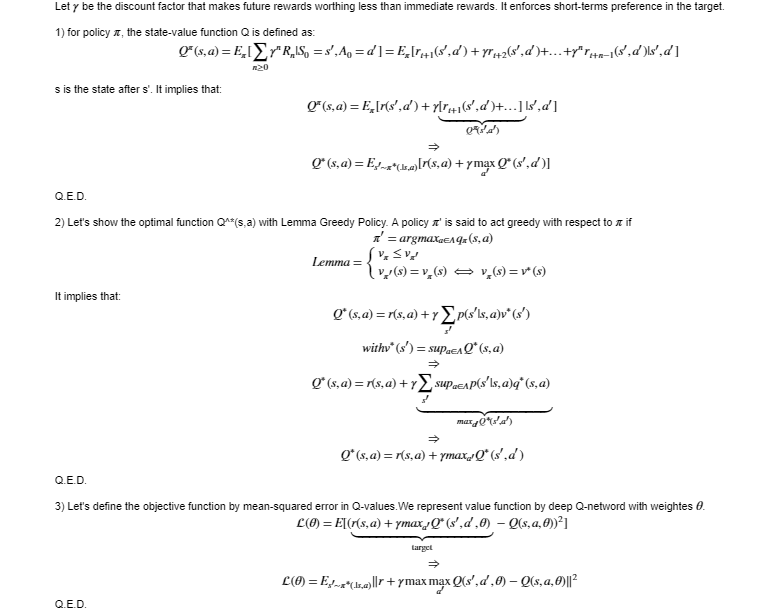

In [100]:
# from IPython.display import Image
# Image(filename='Q5_Answer.png')

Let $\gamma$ be the discount factor that makes future rewards worthing less than immediate rewards. It enforces short-terms preference in the target.
***

1) for policy $\pi$, the state-value function Q is defined as:
\begin{equation*}
Q^{\pi}(s,a)=E_{\pi}[\sum_{n \geq 0} \gamma^n R_n| S_0=s',A_0=a']
            = E_{\pi}[r_{t+1}( s',a')+\gamma r_{t+2}( s',a')+...+\gamma^nr_{t+n-1}( s',a')| s',a']
\end{equation*}

s is the state after s'. It implies that:
\begin{equation*}
Q^{\pi}(s,a)= E_{\pi}[r( s',a')+\gamma \underbrace{[r_{t+1}( s',a')+...]}_\text{$Q^{\pi}(s',a')$}| s',a']\\
	\Rightarrow \\
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')]
\end{equation*}



Q.E.D. 

2) Let's show the optimal function Q^*(s,a) with Lemma Greedy Policy. A policy $\pi$' is said to act greedy with respect to $\pi$ if 
\begin{equation*}
\pi '= argmax_{a \in A}q_{\pi}(s,a) 
\end{equation*}
$$
Lemma = \left\{
    \begin{array}{l}
        v_{\pi} \leq v_{\pi'}\\
        v_{\pi'}(s)=v_{\pi}(s) \iff v_{\pi}(s)=v^*(s) 
    \end{array}
\right.
$$

It implies that:
\begin{equation*}
Q^{*}(s,a)=r(s,a)+ \gamma \sum_{s'}p(s'|s,a)v^*(s') \\
with v^*(s')=sup_{a \in A} Q^*(s,a)\\
\Rightarrow \\
Q^{*}(s,a)=r(s,a)+ \gamma \underbrace{ \sum_{s'} sup_{a \in A}p(s'|s,a)q^*(s,a) }_\text{$max_{a'}Q^*(s',a')$}\\
\Rightarrow \\
Q^{*}(s,a)=r(s,a)+ \gamma max_{a'}Q^*(s',a')
\end{equation*}


Q.E.D.

3) Let's define the objective function by mean-squared error in Q-values.We represent value function by deep Q-netword with weightes $\theta$.
\begin{equation*}
\mathcal{L}(\theta)=E[(\underbrace{r(s,a)+ \gamma max_{a'}Q^*(s',a',\theta)}_\text{target} - Q(s,a,\theta))^2]\\
\Rightarrow\\
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}
\end{equation*}
Q.E.D.

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [60]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()
        # self.discount = discount
        # self.model = model
        # self.num_actions = model.output_shape[-1]

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory) > self.max_memory:
            del self.memory[0]
        return self.memory

    def random_access(self):
        #display(len(self.memory))
        num = np.random.randint(len(self.memory))
        return self.memory[num]


***
The pipeline we will use for training is given below:

In [61]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [62]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        move_ = self.model.predict(s[np.newaxis,:])
        return np.argmax(move_)

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        # https://www.samyzaf.com/ML/rl/qmaze.html
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            s_, n_s_, a_, r_, game_over_ = self.memory.random_access()
            #target_q[i] = #la fct Q, mais il manque des parametres
            
            if game_over_:
                target_reward = r_
                ######## FILL IN
            else:
                ######## FILL IN
                target_reward = r_ + self.discount * np.max(self.model.predict(n_s_[np.newaxis,:]))
                # https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
                #https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1
            input_states[i] = s_    
            target_q[i] = self.model.predict(s_[np.newaxis,:]) 
            target_q[i][a_] = target_reward
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)

        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        
        ####### FILL IN
        model = Sequential()
        model.add(Reshape((5*5*self.n_state,), input_shape=(5,5,self.n_state)))
        model.add(Dense(32, input_dim=5*5*self.n_state, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4, activation='linear')
                  
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()       

In [83]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 50)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 24)                1224      
_________________________________________________________________
dropout_17 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 24)                600       
_________________________________________________________________
dropout_18 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 100       
Total params: 1,924
Trainable params: 1,924
Non-trainable params: 0
_________________________________________________________________
Epoch 00

Epoch 119/200 | Loss 0.0293 | Win/lose count 4.0/9.0 (-5.0)
Epoch 120/200 | Loss 0.0020 | Win/lose count 2.5/3.0 (-0.5)
Epoch 121/200 | Loss 0.0000 | Win/lose count 1.5/4.0 (-2.5)
Epoch 122/200 | Loss 0.0217 | Win/lose count 4.0/8.0 (-4.0)
Epoch 123/200 | Loss 0.0000 | Win/lose count 3.0/10.0 (-7.0)
Epoch 124/200 | Loss 0.0096 | Win/lose count 3.5/4.0 (-0.5)
Epoch 125/200 | Loss 0.0121 | Win/lose count 4.0/2.0 (2.0)
Epoch 126/200 | Loss 0.0021 | Win/lose count 2.5/3.0 (-0.5)
Epoch 127/200 | Loss 0.0076 | Win/lose count 1.0/4.0 (-3.0)
Epoch 128/200 | Loss 0.0020 | Win/lose count 2.5/3.0 (-0.5)
Epoch 129/200 | Loss 0.0022 | Win/lose count 3.0/1.0 (2.0)
Epoch 130/200 | Loss 0.0000 | Win/lose count 4.0/6.0 (-2.0)
Epoch 131/200 | Loss 0.0081 | Win/lose count 2.0/6.0 (-4.0)
Epoch 132/200 | Loss 0.0078 | Win/lose count 4.0/11.0 (-7.0)
Epoch 133/200 | Loss 0.0110 | Win/lose count 1.5/8.0 (-6.5)
Epoch 134/200 | Loss 0.0000 | Win/lose count 3.5/5.0 (-1.5)
Epoch 135/200 | Loss 0.0155 | Win/lose c

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [68]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential()
        model.add(Conv2D(32,kernel_size=(2,2),input_shape=(5,5,self.n_state), activation='relu'))
        model.add(Conv2D(32,kernel_size=(2,2),activation='relu'))
        model.add(Flatten())
        model.add(Dense(4,activation ="linear"))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        model.summary()

In [69]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train10.mp4'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 32)          4128      
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 1156      
Total params: 5,572
Trainable params: 5,572
Non-trainable params: 0
_________________________________________________________________
Epoch 000/200 | Loss 0.0130 | Win/lose count 9.0/9.0 (0.0)
Epoch 001/200 | Loss 0.0081 | Win/lose count 5.5/1.0 (4.5)
Epoch 002/200 | Loss 0.0036 | Win/lose count 8.0/7.0 (1.0)
Epoch 003/200 | Loss 0.0640 | Win/lose count 6.5/9.0 (-2.5)
Epoch 004/200 | Loss 0.0056 | Win/l

Epoch 122/200 | Loss 0.0023 | Win/lose count 18.0/4.0 (14.0)
Epoch 123/200 | Loss 0.0025 | Win/lose count 23.5/4.0 (19.5)
Epoch 124/200 | Loss 0.0017 | Win/lose count 21.5/1.0 (20.5)
Epoch 125/200 | Loss 0.0039 | Win/lose count 10.5/3.0 (7.5)
Epoch 126/200 | Loss 0.0038 | Win/lose count 10.0/2.0 (8.0)
Epoch 127/200 | Loss 0.0016 | Win/lose count 13.5/2.0 (11.5)
Epoch 128/200 | Loss 0.0079 | Win/lose count 14.5/4.0 (10.5)
Epoch 129/200 | Loss 0.0085 | Win/lose count 14.5/6.0 (8.5)
Epoch 130/200 | Loss 0.0024 | Win/lose count 13.0/1.0 (12.0)
Epoch 131/200 | Loss 0.0530 | Win/lose count 20.5/4.0 (16.5)
Epoch 132/200 | Loss 0.0538 | Win/lose count 25.0/5.0 (20.0)
Epoch 133/200 | Loss 0.0029 | Win/lose count 19.5/2.0 (17.5)
Epoch 134/200 | Loss 0.0026 | Win/lose count 14.5/4.0 (10.5)
Epoch 135/200 | Loss 0.0032 | Win/lose count 15.0/3.0 (12.0)
Epoch 136/200 | Loss 0.0037 | Win/lose count 13.0/4.0 (9.0)
Epoch 137/200 | Loss 0.0024 | Win/lose count 19.0/3.0 (16.0)
Epoch 138/200 | Loss 0.0484 

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [93]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 3, 3, 32)          4128      
_________________________________________________________________
flatten_10 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 1156      
Total params: 5,572
Trainable params: 5,572
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 50)                0         
_________________________________________________________________
dense_45

Win/lose count 1.5/3.0. Average score (-0.7727272727272727)
Win/lose count 2.0/3.0. Average score (-0.7747747747747747)
Win/lose count 2.5/2.0. Average score (-0.7633928571428571)
Win/lose count 3.0/3.0. Average score (-0.7566371681415929)
Win/lose count 2.5/3.0. Average score (-0.7543859649122807)
Win/lose count 4.0/2.0. Average score (-0.7304347826086957)
Win/lose count 2.0/5.0. Average score (-0.75)
Win/lose count 5.5/4.0. Average score (-0.7307692307692307)
Win/lose count 2.5/3.0. Average score (-0.7288135593220338)
Win/lose count 1.0/3.0. Average score (-0.7394957983193278)
Win/lose count 2.0/1.0. Average score (-0.725)
Win/lose count 3.0/6.0. Average score (-0.743801652892562)
Win/lose count 2.0/4.0. Average score (-0.7540983606557377)
Win/lose count 2.5/5.0. Average score (-0.7682926829268293)
Win/lose count 1.0/2.0. Average score (-0.7701612903225806)
Win/lose count 1.5/3.0. Average score (-0.776)
Win/lose count 1.5/3.0. Average score (-0.7817460317460317)
Win/lose count 1.0/1.

Win/lose count 5.0/7.0. Average score (-0.7884615384615384)
Win/lose count 3.0/2.0. Average score (-0.7547169811320755)
Win/lose count 3.5/9.0. Average score (-0.8425925925925926)
Win/lose count 3.0/3.0. Average score (-0.8272727272727273)
Win/lose count 8.5/4.0. Average score (-0.7321428571428571)
Win/lose count 3.5/5.0. Average score (-0.7456140350877193)
Win/lose count 7.0/8.0. Average score (-0.75)
Win/lose count 3.0/1.0. Average score (-0.7033898305084746)
Win/lose count 2.5/5.0. Average score (-0.7333333333333333)
Win/lose count 1.5/3.0. Average score (-0.7459016393442623)
Win/lose count 3.5/5.0. Average score (-0.7580645161290323)
Win/lose count 2.5/3.0. Average score (-0.753968253968254)
Win/lose count 1.5/2.0. Average score (-0.75)
Win/lose count 1.5/4.0. Average score (-0.7769230769230769)
Win/lose count 2.0/4.0. Average score (-0.7954545454545454)
Win/lose count 3.0/7.0. Average score (-0.8432835820895522)
Win/lose count 3.5/4.0. Average score (-0.8382352941176471)
Win/lose 

Win/lose count 4.0/3.0. Average score (-0.9947916666666666)
Win/lose count 3.0/3.0. Average score (-0.9896373056994818)
Win/lose count 3.5/6.0. Average score (-0.9974226804123711)
Win/lose count 6.0/2.0. Average score (-0.9717948717948718)
Win/lose count 6.5/10.0. Average score (-0.9846938775510204)
Win/lose count 2.0/3.0. Average score (-0.9847715736040609)
Win/lose count 4.0/3.0. Average score (-0.9747474747474747)
Win/lose count 4.0/5.0. Average score (-0.9748743718592965)
Win/lose count 2.0/4.0. Average score (-0.98)
Final score: -0.98


In [94]:
HTML(display_videos('cnn_test10.mp4'))

In [95]:
HTML(display_videos('fc_test10.mp4'))

# change temperatur to 0.6

In [96]:
# change temperature to 0.6
env = Environment(grid_size=size, max_time=T,temperature=0.6)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 3, 3, 32)          4128      
_________________________________________________________________
flatten_11 (Flatten)         (None, 288)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 1156      
Total params: 5,572
Trainable params: 5,572
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 50)                0         
_________________________________________________________________
dense_49

Win/lose count 5.0/2.0. Average score (0.9776785714285714)
Win/lose count 3.5/3.0. Average score (0.9734513274336283)
Win/lose count 6.0/4.0. Average score (0.9824561403508771)
Win/lose count 3.5/3.0. Average score (0.9782608695652174)
Win/lose count 3.0/2.0. Average score (0.978448275862069)
Win/lose count 6.5/5.0. Average score (0.9829059829059829)
Win/lose count 3.5/3.0. Average score (0.9788135593220338)
Win/lose count 5.5/3.0. Average score (0.9915966386554622)
Win/lose count 4.5/2.0. Average score (1.0041666666666667)
Win/lose count 6.0/5.0. Average score (1.0041322314049588)
Win/lose count 5.0/5.0. Average score (0.9959016393442623)
Win/lose count 7.5/7.0. Average score (0.991869918699187)
Win/lose count 2.5/3.0. Average score (0.9798387096774194)
Win/lose count 6.0/4.0. Average score (0.988)
Win/lose count 6.0/8.0. Average score (0.9642857142857143)
Win/lose count 2.0/1.0. Average score (0.9645669291338582)
Win/lose count 4.5/4.0. Average score (0.9609375)
Win/lose count 6.0/2.

Win/lose count 6.0/3.0. Average score (1.6071428571428572)
Win/lose count 11.0/5.0. Average score (1.6842105263157894)
Win/lose count 5.0/6.0. Average score (1.6379310344827587)
Win/lose count 3.0/3.0. Average score (1.6101694915254237)
Win/lose count 8.5/1.0. Average score (1.7083333333333333)
Win/lose count 4.0/4.0. Average score (1.680327868852459)
Win/lose count 6.0/2.0. Average score (1.717741935483871)
Win/lose count 3.5/1.0. Average score (1.7301587301587302)
Win/lose count 8.5/3.0. Average score (1.7890625)
Win/lose count 7.5/4.0. Average score (1.8153846153846154)
Win/lose count 10.0/7.0. Average score (1.8333333333333333)
Win/lose count 7.0/5.0. Average score (1.835820895522388)
Win/lose count 6.0/3.0. Average score (1.8529411764705883)
Win/lose count 4.0/4.0. Average score (1.826086956521739)
Win/lose count 7.0/4.0. Average score (1.8428571428571427)
Win/lose count 9.5/3.0. Average score (1.908450704225352)
Win/lose count 3.5/4.0. Average score (1.875)
Win/lose count 6.5/4.0

Win/lose count 9.0/9.0. Average score (1.5505050505050506)
Win/lose count 5.5/5.0. Average score (1.5452261306532664)
Win/lose count 5.0/3.0. Average score (1.5475)
Final score: 1.5475


In [97]:
HTML(display_videos('cnn_test10.mp4'))

In [98]:
HTML(display_videos('fc_test10.mp4'))

The $\textbf{test}$ phrase of both fully connected layers and CNN performs poorly. The agent gets negative average scores, -0.77 for CNN and -0.98 for FC. The agent is not motivated to explore area far away from himself.

By doubling the temperature to 0.6, we observe that:

1) increasing temperatur helps the agent to achieves better average scores with fully-connected layer model and CNN model. The average score is improved considerably (comparing to temperature = 0.3): 0.96 vs -0.77 for CNN and 1.55 vs -0.98 for FC


2) fully connected algorithm converges faster than CNN.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [ ]:
def train_explore(agent,env,epoch,prefix=''):
    pass
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        pass
    
## use those samples of code:
#In train explore:
state, reward, game_over = env.act(action, train=True)

## In Environment exploring:
# You will have to change n_state to 3 because you will use one more layer!
reward = 0
if train:
    reward = -self.malus_position[self.x, self.y]
self.malus_position[self.x, self.y] = 0.1

reward = reward + self.board[self.x, self.y]
# 3 "feature" states instead of 2
state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

In [ ]:
# Training
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

In [ ]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***